In [17]:
# !pip install xgboost

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# Read in the data
df = pd.read_csv('../Data/Final_skin_cancer.csv')
df.drop('drink', axis=1, inplace=True)


In [20]:
from sklearn.model_selection import train_test_split

def splitting_data(df, sampling, test_size=0.2, random_state=123):
    # First, split the data into features and target variable
    X = df.drop(['diagnostic'], axis=1)
    y = df['diagnostic']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Apply sampling methods to the training data based on the specified method
    if sampling == 'none':
        return X_train, X_test, y_train, y_test
    elif sampling == 'SMOTEENN':
        from imblearn.combine import SMOTEENN
        smote_enn = SMOTEENN(random_state=random_state)
        X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'SMOTE':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'under':
        from imblearn.under_sampling import RandomUnderSampler
        rus = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test


In [21]:
def training_using_diff_lr(X_train, y_train, X_test, y_test):
    learning_rate_range = np.arange(0.01, 1, 0.05)
    test_XG = [] 
    train_XG = []
    best_classifier = None
    best_accuracy = 0

    for lr in learning_rate_range:
        xgb_classifier = xgb.XGBClassifier(eta=lr)
        xgb_classifier.fit(X_train, y_train)
        train_accuracy = xgb_classifier.score(X_train, y_train)
        test_accuracy = xgb_classifier.score(X_test, y_test)
        train_XG.append(train_accuracy)
        test_XG.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_classifier = xgb_classifier

    fig, ax = plt.subplots(1, 2, figsize=(20, 7))

    # Plotting accuracy vs. learning rate
    ax[0].plot(learning_rate_range, train_XG, c='orange', label='Train')
    ax[0].plot(learning_rate_range, test_XG, c='m', label='Test')
    ax[0].set_xlabel('Learning rate')
    ax[0].set_xticks(learning_rate_range)
    ax[0].set_ylabel('Accuracy score')
    ax[0].set_ylim(0.6, 1)
    ax[0].legend(prop={'size': 12}, loc=3)
    ax[0].set_title('Accuracy score vs. Learning rate of XGBoost', size=14)

    if best_classifier:
        # Printing classification report
        y_pred = best_classifier.predict(X_test)
        print("Classification Report of the Best Classifier:")
        print(classification_report(y_test, y_pred))

        # Plotting confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", ax=ax[1])
        ax[1].set_title('Confusion Matrix of the Best Classifier')
        ax[1].set_xlabel('Predicted')
        ax[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

    return best_classifier, test_XG, train_XG




In [22]:
def grid_search(X_train, y_train, X_test, y_test):
    xgb_classifier = xgb.XGBClassifier()
    parameters = {
            'eta': np.arange(0.01, 1, 0.05),
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            }
    grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Classification Report
    print("Classification Report of the Best Classifier:")
    print(classification_report(y_test, y_pred))

    # Best Parameters and Accuracy
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix of the Best Classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return best_model


<h1> XGboost using original data </h1>

In [23]:
#splitting the data
X_train, X_test, y_train, y_test = splitting_data(df, 'none')
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Classification Report of the Best Classifier:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        39
           1       0.97      0.99      0.98       302

    accuracy                           0.96       341
   macro avg       0.93      0.89      0.91       341
weighted avg       0.96      0.96      0.96       341



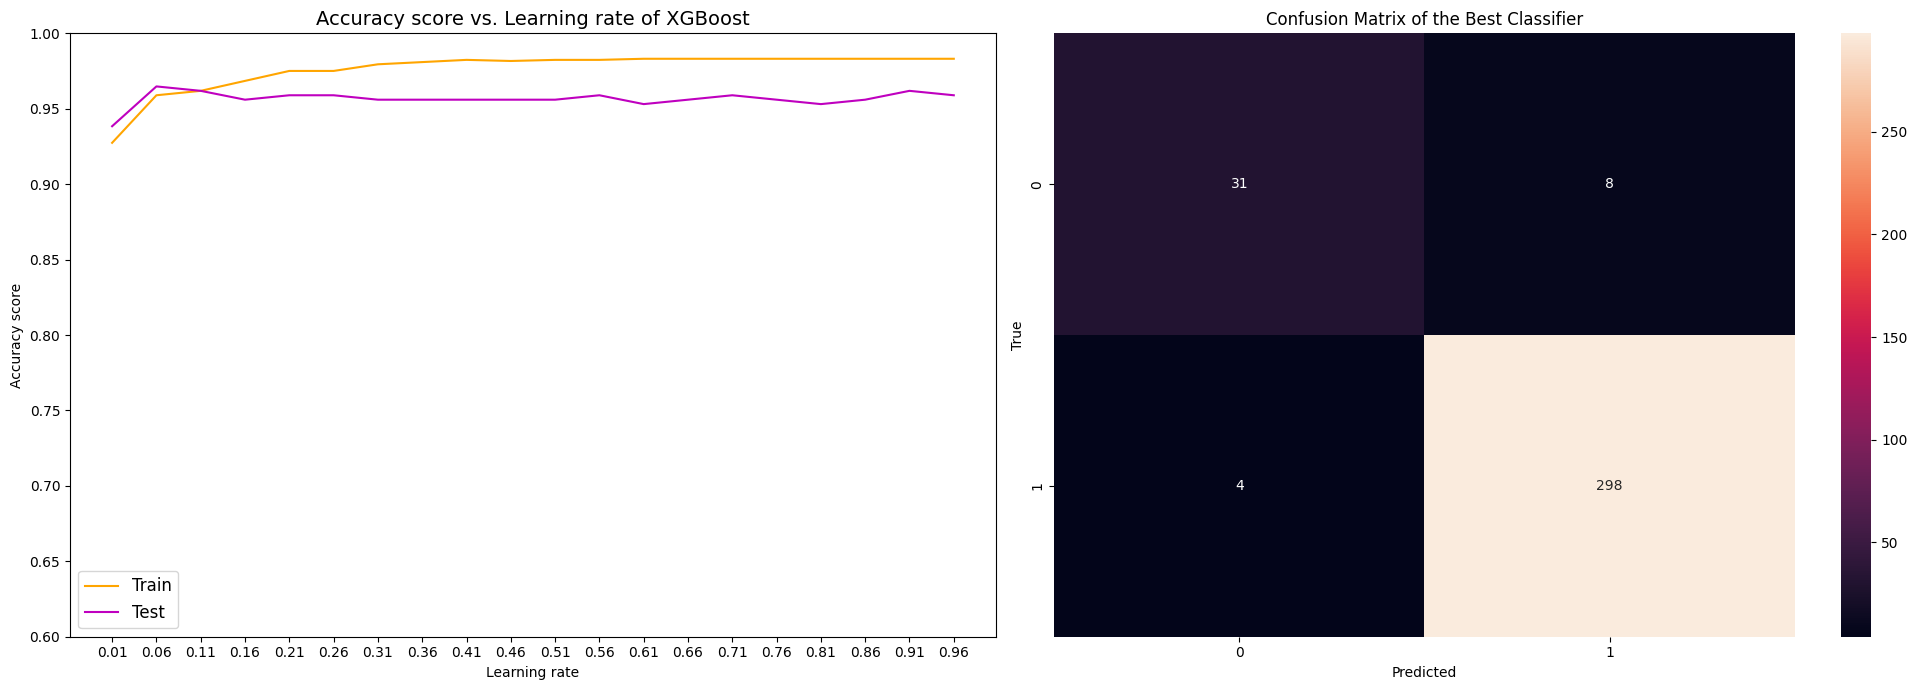

In [24]:
model, train, test = training_using_diff_lr(X_train, y_train, X_test, y_test)

In [25]:
print("Best Learning Rate: ", model.get_params()['eta'])

Best Learning Rate:  0.060000000000000005


In [26]:
# model = grid_search(X_train, y_train, X_test, y_test)

In [27]:
# #saving the model
# !pip install joblib
# import joblib
# joblib.dump(model, '/Users/shahadaleissa/hyper_code/Models/xgboost_model.joblib')